In [223]:
import numpy as np
s = 2 *3

def _compute_cphi(phi, y):  # (n,s) first,third var: n or n_t
    pre_cphi = y[:, :, np.newaxis] * phi.reshape((len(y), 2, -1))  # (n,s)
    return pre_cphi.reshape((len(y), -1))


y = np.array([1,5]).reshape((1,-1))
rest = np.random.rand(s,1)
phi_test = np.random.rand(1,s)
cphi_test = _compute_cphi(phi_test, y)
print('rest is: ', rest)
print('phi_test is: ', phi_test)
print('cphi_test is: ', cphi_test)
print('product', cphi_test @ rest)
print('phi_test_re', phi_test.reshape((2,-1)))
print('rest_re', rest.reshape((-1,2), order='F'))
mean_var = np.einsum('ij,ji->i', phi_test.reshape((2,-1)), rest.reshape((-1,2),order='F'))
print('mean_var', mean_var)
print(y @ mean_var)



rest is:  [[0.53930007]
 [0.31152062]
 [0.70395932]
 [0.50189089]
 [0.67023155]
 [0.55024562]]
phi_test is:  [[0.93058971 0.50079608 0.34606321 0.86009612 0.44976726 0.22739169]]
cphi_test is:  [[0.93058971 0.50079608 0.34606321 4.30048058 2.24883629 1.13695843]]
product [[5.19270926]]
phi_test_re [[0.93058971 0.50079608 0.34606321]
 [0.86009612 0.44976726 0.22739169]]
rest_re [[0.53930007 0.50189089]
 [0.31152062 0.67023155]
 [0.70395932 0.55024562]]
mean_var [0.90148982 0.85824389]
[5.19270926]


In [246]:
# import numpy as np
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# initial_x0s = np.mgrid[0.1 : np.pi : 1, -1:1.1:0.4, 0 : np.pi : 1, -1:1.1:0.4].reshape(4, -1).T
    
# print(initial_x0s)

In [225]:
import numpy as np
swift_path = "/share/dean/fast_control/models/swift_grid/"
name = "grid_225_100_steps.npz"
data = np.load(swift_path + name)
xs, ys, zs = data['xs'], data['ys'], data['zs']
print(xs.shape)
print(ys.shape)
print(zs.shape)
pruned_data = xs[::5]
print(pruned_data.shape)

(11074, 4)
(11074, 3)
(11074,)
(2215, 4)


In [3]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import time
colwidth = 9/2.54  # 9 cm
plt.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['text.usetex'] = False
sns.set(style="ticks")

# plt.rc('font', family='serif')
# plt.rc('font', serif='Times New Roman')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_palette("muted")

In [8]:

def plotit(ts, qp_cs, oracle_cs, gp_cs, names, c_cdot, plot_path):
    # colors =[#6fc6ab,#fc8b5f,#8caacb,#e683bf,#abda5e]
    plt.figure(figsize=(6,4))
    sns.lineplot(
        x=ts,
        y=qp_cs[c_cdot],
        linestyle="dotted",
        color="black",
        label="nominal",
    )
    sns.lineplot(
        x=ts,
        y=oracle_cs[c_cdot],
        linestyle="dashdot",
        color="black",
        label="oracle",
    )
    s = 250
    offset = [0,.5,1,1.5]
    y_offset = 4
    sns.lineplot(x=ts,y=gp_cs[0,c_cdot],label=names[0],alpha=0.5)
    plt.scatter(ts[-1]-offset[3], gp_cs[0,c_cdot,-1]+y_offset, marker='*', s= s, color=sns.color_palette('muted')[0])
    sns.lineplot(x=ts,y=gp_cs[2,c_cdot],label=names[2],alpha=0.5)
    plt.scatter(ts[-1]-offset[2], gp_cs[2,c_cdot,-1]+y_offset, marker='d', s= s, color=sns.color_palette('muted')[1])
    sns.lineplot(x=ts,y=gp_cs[1,c_cdot],label=names[1],alpha=0.5)
    plt.scatter(ts[-1]-offset[1], gp_cs[1,c_cdot,-1]+y_offset, marker='^', s= s, color=sns.color_palette('muted')[2])
    sns.lineplot(x=ts,y=gp_cs[3,c_cdot],label=names[3],alpha=0.5)
    plt.scatter(ts[-1]-offset[0], gp_cs[3,c_cdot,-1]+y_offset, marker='s', s= s, color=sns.color_palette('muted')[3])


    plt.xlabel("time(s)")
    plt.ylabel('$C(x)$')
    plt.tight_layout()
    plt.grid(True)
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    # plt.figure(figsize=(1.5,2))
    plt.savefig(plot_path, dpi=300)
    plt.show()
    plt.close()    

/tmp/ipykernel_1784428/1813683843.py:36: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


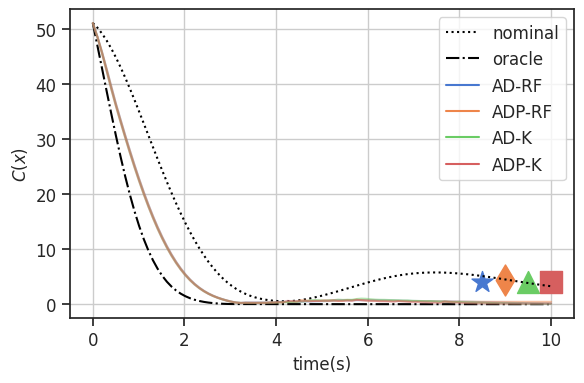

In [9]:
import numpy as np
from plant_factory import ControllerFactory
from swift_control.eval import eval_cs
swift_path = "/share/dean/fast_control/models/swift_grid/"
file_path = swift_path + "warm_episodic/linear_static_cost/"
plant_conf = swift_path + "base_config.toml"
plot_path = swift_path + "paper/"
qp_cs = np.load(file_path+"qp_cs.npy")
x_0 = np.array([2.0, 0.0, 0.0, 0.0])
plant = ControllerFactory(plant_conf)
kwargs = x_0, plant.episodic_T, plant.episodic_num_steps
oracle_cs, ts = eval_cs(plant.system, plant.oracle_controller, *kwargs)
gp_cs =  np.load(file_path+"gp_cs.npy")
names = ['AD-RF','AD-K','ADP-RF','ADP-K']
ts = np.linspace(0,10,100)
plotit(ts, qp_cs, oracle_cs, gp_cs, names, 0, plot_path)
# plotit(ts, qp_cs, oracle_cs, gp_cs, names, 1, plot_path)


In [251]:
# import numpy as np 
# import matplotlib.pyplot as plt

# X = np.array([[1,1], [2,2.5], [3, 1], [8, 7.5], [7, 9], [9, 9]])
# Y = ['red', 'red', 'red', 'blue', 'blue', 'blue']
# plt.scatter(X[:, 0], X[:, 1], s = 170, color = Y[:])
# t1 = plt.Polygon(X[:3,:], color=Y[0])
# plt.gca().add_patch(t1)

# t2 = plt.Polygon(X[3:6,:], color=Y[3])
# plt.gca().add_patch(t2)

# plt.show()

In [13]:

# sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_palette("muted")
def plot(data, v_data, name, train_time, gp_names, yscale=False):

    cutoff = 40
    sns.color_palette("Set2",4)
    plot_path = "/share/dean/fast_control/models/swift_grid/paper/"
    steps = data.shape[1]
    pre_xs = 2 * np.arange(100, steps * 101, 100)[:cutoff]
    xs = np.tile(pre_xs, 10)

    data = data[:, :cutoff, :]
    v_data = v_data[0,:cutoff,:]
    train_time = train_time[:, :cutoff]
    plt.figure(figsize=(6,4))
    ax = sns.lineplot(
        x=xs,
        y=data[0, :, :].flatten("F"), 
        estimator=np.median,
        errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
        label=gp_names[0],
    )

    ax2 = sns.lineplot(
        x=xs,
        y=data[2, :, :].flatten("F"),
        estimator=np.median,
        errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
        label=gp_names[2],
    )
    offset = 0.1
    ax3 = sns.lineplot(x=xs, y=data[1, :, :].flatten("F"), label=gp_names[1],alpha=0.5)
    plt.scatter(xs[-0], data[1,0,0]-offset, marker='^', s=100, color=sns.color_palette('muted')[2])
    ax4 = sns.lineplot(x=xs, y=data[3, :, :].flatten("F"), label=gp_names[3],alpha=0.5)
    plt.scatter(xs[0], data[3,0,0]+offset, marker='s', s=100, color=sns.color_palette('muted')[3])
    # color4 = ax4.get_color()

    sns.lineplot(x=xs, y=v_data.flatten("F"), label=gp_names[4])
    # ax2 = plt.twinx()
    # for i in range(4):
    #     sns.lineplot(x=pre_xs, y=train_time[i,:30], ax=ax2)
    # sns.lineplot(x=xs, y=test_time, ax=ax2, label="test_time")
    
    # ax2.set_ylabel("train time(s)")
    # plt.yscale("log")
    if yscale:
        ax.set(yscale="log")
        ax2.set(yscale="log")
        ax3.set(yscale="log")
        ax4.set(yscale="log")
    plt.xlabel("feature dimension")
    ax.set_ylabel(f"{name}")
    plt.ylim(5,7)
    plt.tight_layout()
    plt.grid(True)
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.savefig(plot_path + f"{name}_grid.png",dpi=300)
    plt.show()

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

def plottof(train_time, names, v_train_time,steps):
    cutoff = 40
    plot_path = "/share/dean/fast_control/models/swift_grid/paper/"
    pre_xs = 2*np.arange(100, steps * 101, 100)[:cutoff]
    print(pre_xs.shape)
    print(train_time.shape)
    plt.figure(figsize=(6,4))
    for i in {0,2}:
        sns.lineplot(x=pre_xs, y=train_time[i,:cutoff], label=names[i])

    offset = 20
    sns.lineplot(x=pre_xs, y=train_time[1,:cutoff], label=names[1])
    plt.scatter(pre_xs[0], train_time[1,0]+offset, marker='^', s=100, color=sns.color_palette('muted')[2])
    sns.lineplot(x=pre_xs, y=train_time[3,:cutoff], label=names[3])
    plt.scatter(pre_xs[0], train_time[3,0]-offset, marker='s', s=100, color=sns.color_palette('muted')[3])
    # plt.yscale("log")
    # plt.gca().add_patch(t1)
    sns.lineplot(x=pre_xs, y=v_train_time[0,:cutoff], label=names[4])
    plt.xlabel("feature dimension")
    plt.ylabel("average train time(s)")
    # sns.lineplot(x=pre_xs, y=train_time[2,:cutoff], alpha=0.5)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plot_path + f"train_time.png",dpi=300)
    plt.show()

/tmp/ipykernel_1784428/1095787377.py:57: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


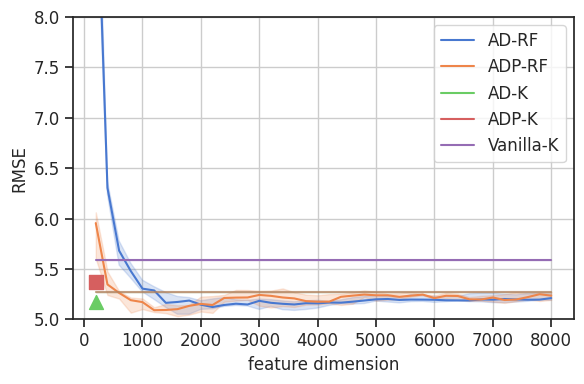

(4, 44)
vtrain_shape(1, 87)
(40,)
(4, 44)


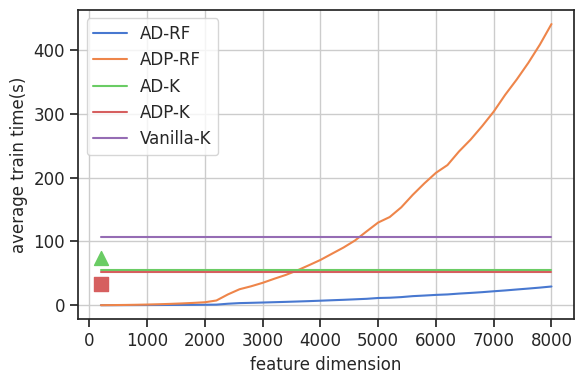

In [15]:
import numpy as np
static_path = "/share/dean/fast_control/models/swift_grid/static_tests/small/"
names = ['AD-RF','AD-K','ADP-RF','ADP-K','Vanilla-K']
rmse = np.load(static_path + "static_tests_rmse_grid.npy")
train_time = np.load(static_path + "static_tests_train_time_grid.npy")
test_time = np.load(static_path + "static_tests_train_time_grid.npy")
v_rmse = np.load(static_path + "vanillarmse_grid.npy")
v_train_time = np.load(static_path + "vanillatrain_time_grid.npy")
# print(train_time.mean(axis=2)[0], rmse.shape[1])
# steps = rmse.shape[1]
# xs = np.arange(100, steps * 101, 100)
# print(xs.shape, np.tile(xs, 10).shape)
# plottof(train_time.mean(axis=2), names)
# plot(rmse, "rmse", train_time.mean(axis=2), test_time.mean(axis=2), names)
# print(train_time[1])
plot(rmse, v_rmse, "RMSE", train_time, names, yscale=False)
# plot(rmse, "RMSE", train_time.mean(axis=2), test_time, names, yscale=True)
print(train_time.shape)
print(f"vtrain_shape{v_train_time.shape}")
plottof(train_time, names, v_train_time, rmse.shape[1])
# plot(mae, "mae", train_time, test_time, names)

In [408]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
def plot_learnsys(preds, labels, ts, gps_names):
    plot_path ="/share/dean/fast_control/models/swift_grid/x_dot_preds/"
    print(labels.shape[0])
    plot_xs = np.tile(ts, labels.shape[0])
    print(ts.shape)
    print(plot_xs.shape)
    for i in range(4):
        plt.figure()
        for  name_idx, name in enumerate(gps_names):
            sns.lineplot(
                x=plot_xs,
                y=preds[name_idx+1,:,:,i].flatten(),
                estimator=np.median,
                errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
                label=name+" $\dot{x}$ prediction",
            )       
        sns.lineplot(x=plot_xs,y=labels[:,:,i].flatten(),estimator=np.median,
            errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
            color='black', linestyle='--',label="true $\dot{x}$")
        plt.xlabel("time")
        plt.ylabel(f"{i}-th coordinate of x_dot")
        plt.tight_layout()
        plt.legend()
        # plt.savefig(f"{plot_path}x_dot_error_{i}_int{time.time()}.png", dpi=300)
        plt.show()
        plt.close()

554
(99,)
(54846,)


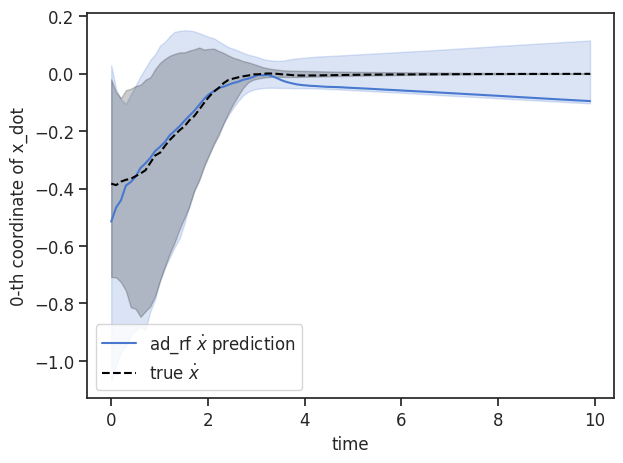

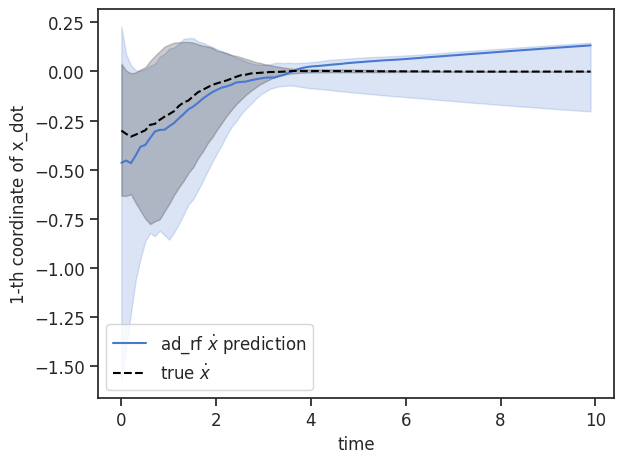

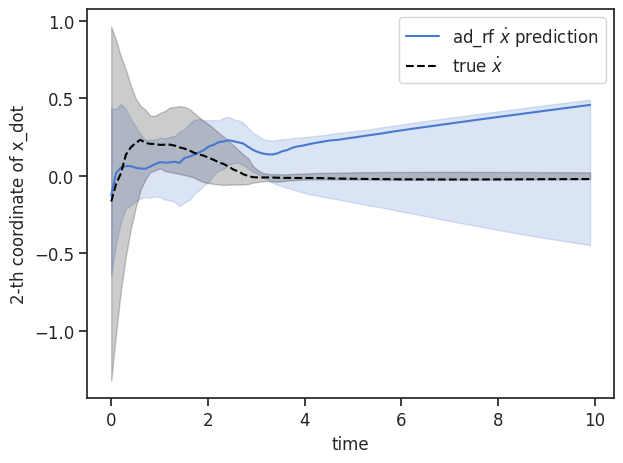

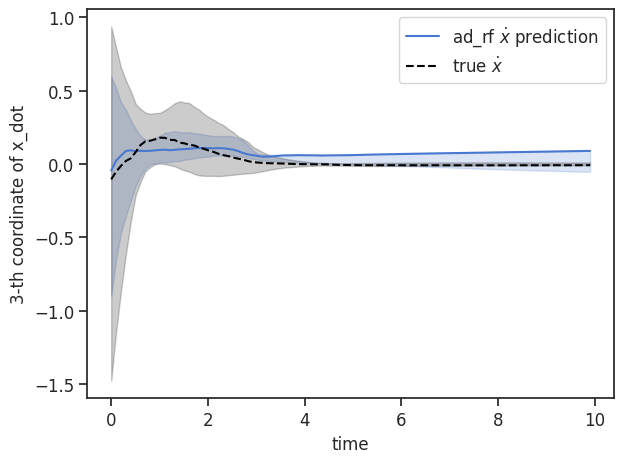

In [409]:
swift_path = "/share/dean/fast_control/models/swift_grid/"
oracle_zs = np.load(swift_path + "x_dot_preds/oracle_zs.npy")
qp_zs = np.load(swift_path + "x_dot_preds/qp_zs.npy")
gp_qp_preds = np.load(swift_path + "x_dot_preds/gp_qp_preds.npy")
gp_or_preds = np.load(swift_path + "x_dot_preds/gp_or_preds.npy")
plot_learnsys(gp_or_preds, oracle_zs, np.linspace(0,10,100)[:-1], ['ad_rf'])

In [410]:
from sklearn.model_selection import train_test_split
grid_data = np.load(swift_path + "grid_225_100_steps.npz")
xs, ys, zs = grid_data["xs"], grid_data["ys"], grid_data["zs"]
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
        np.asarray(xs), np.asarray(ys), np.asarray(zs), test_size=0.20, shuffle=True
    )
print(zs.shape)
zs = np.zeros(100)
num = len(zs) // 9
rf_d = num + 1 if num % 2 else num  # FIXME:rf_d
rf_d = 2 * rf_d
print(rf_d)
print(z_train.shape)
print(z_test.shape)
x = np.array([[1,2,3],[4,5,6]]).T
u =np.array([[1,1,1]]).T
print(u.shape)

print(x)
print(x.shape)
xu = np.concatenate((x, u), axis=1)
print(xu)
print(np.inner(x,x))

(11074,)
24
(8859,)
(2215,)
(3, 1)
[[1 4]
 [2 5]
 [3 6]]
(3, 2)
[[1 4 1]
 [2 5 1]
 [3 6 1]]
[[17 22 27]
 [22 29 36]
 [27 36 45]]


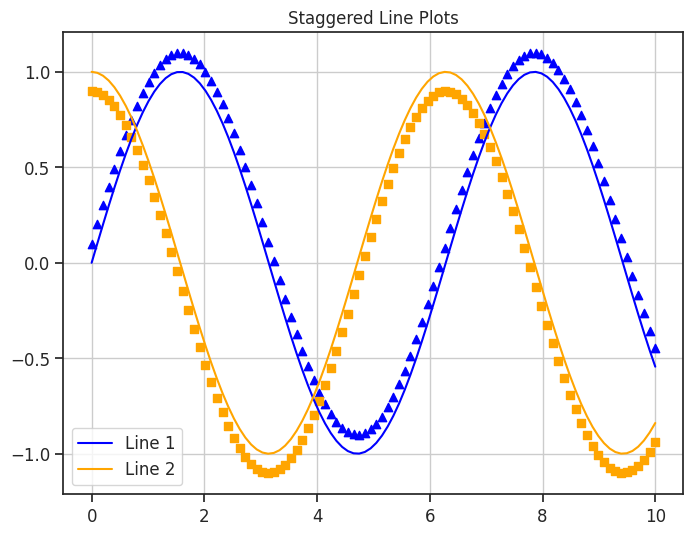

In [411]:
import matplotlib.pyplot as plt
import numpy as np

# Create some sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the original lines
plt.plot(x, y1, label='Line 1', color='blue')
plt.plot(x, y2, label='Line 2', color='orange')

# Add deltas or squares above each point with a vertical offset
offset = 0.1  # You can adjust this offset based on your preference
plt.scatter(x, y1 + offset, marker='^', color='blue')
plt.scatter(x, y2 - offset, marker='s', color='orange')

# Customize the plot
plt.title('Staggered Line Plots')
plt.legend()
plt.grid(True)